In [2]:
import torch
from src.configs import *
from src.gan_models import *
import time
import matplotlib.pyplot as plt

In [3]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

# device = torch.device('cpu')

MPS is available on this device.


# Load model

In [30]:
model_path = 'models/generator_model_sndcgan256_hinge_600.pt'
# model_path = 'models/generator_model_128_151.pt'

g_model = DCGANGeneratorNet256()  # Ensure the class is defined or imported
g_model.load_state_dict(torch.load(model_path, map_location=device))
g_model.to(device)
g_model.eval()  # Set to evaluation mode if not training further

DCGANGeneratorNet256(
  (cons_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(128, 1, 1))
    (1): ConvTranspose2d(128, 4096, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): FReLU(inplace=True, bias=(torch.Size([1])))
    (4): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): FReLU(inplace=True, bias=(torch.Size([1])))
    (7): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): FReLU(inplace=True, bias=(torch.Size([1])))
    (10): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): FReLU(inplace=True, bias=

In [51]:
# g_model.to('cpu')
# torch.save(g_model.state_dict(), 'models/generator_model_impressionist_150_cpu.pth')

In [34]:
n_sample_points = 80

def create_trajectory(start, end, n_samples, device):
    direction = end - start
    trajectory = [start + (i * direction) / (n_samples + 1) for i in range(n_samples + 2)] 
    
    return trajectory 

def get_orthogonal_point(point):
    orthogonal = torch.linalg.svd(point)
    print(orthogonal.Vh)
    
def find_farest_point(point):
    max_attempt = 100
    test_point = torch.randn(1, LATENT_DIM).to(device)
    farest_point = test_point
    max_dist = 0
    for i in range(max_attempt):
        test_point = torch.randn(1, LATENT_DIM).to(device) 
        dist = torch.linalg.norm(point - test_point)
        if dist > max_dist:
            max_dist = dist
            farest_point = test_point
    
    print(f'Distance: {torch.linalg.norm(point - farest_point)}')
    return farest_point

def find_random_point(point):
    farest_point = torch.randn(1, LATENT_DIM).to(device)
    return farest_point
    

start_point = torch.randn(1, LATENT_DIM).to(device)
# end_point = torch.randn(1, LATENT_DIM).to(device)
end_point = find_farest_point(start_point)
# end_point = get_orthogonal_point(start_point) 
# start_point = torch.full((1, LATENT_DIM), -1, device=device)
# end_point = torch.full((1, LATENT_DIM), 1, device=device)

trajectory = create_trajectory(start_point, end_point, n_sample_points, device)

tr2 = create_trajectory(end_point, find_farest_point(end_point), n_sample_points, device)

trajectory = trajectory + tr2

print(f'Total Trajectory: {len(trajectory)}')

generated_images = []
cost_times = []

for idx, inter_point in enumerate(trajectory):
    start_ts = time.time()
    output = g_model(inter_point)
    img = output[0, :, :, :].detach().cpu().permute(1, 2, 0).numpy()
    normalized_img = (img + 1) / 2
    generated_images.append(normalized_img) 
    cost_ts = (time.time() - start_ts) * 1000
    cost_times.append(cost_ts) 
    print(f'[{idx}]Image generated in {cost_ts} ms')

print(f'Generated images: {len(generated_images)}')



Distance: 17.414791107177734
Distance: 18.886171340942383
Total Trajectory: 164
[0]Image generated in 815.2081966400146 ms
[1]Image generated in 49.47686195373535 ms
[2]Image generated in 48.39515686035156 ms
[3]Image generated in 49.50094223022461 ms
[4]Image generated in 49.00622367858887 ms
[5]Image generated in 51.11408233642578 ms
[6]Image generated in 49.5600700378418 ms
[7]Image generated in 50.093889236450195 ms
[8]Image generated in 48.68197441101074 ms
[9]Image generated in 48.4769344329834 ms
[10]Image generated in 50.4908561706543 ms
[11]Image generated in 49.73602294921875 ms
[12]Image generated in 49.41916465759277 ms
[13]Image generated in 50.041913986206055 ms
[14]Image generated in 49.43394660949707 ms
[15]Image generated in 50.88210105895996 ms
[16]Image generated in 49.68094825744629 ms
[17]Image generated in 48.506975173950195 ms
[18]Image generated in 48.54011535644531 ms
[19]Image generated in 48.3701229095459 ms
[20]Image generated in 49.851179122924805 ms
[21]Im

Text(0, 0.5, 'Time (ms)')

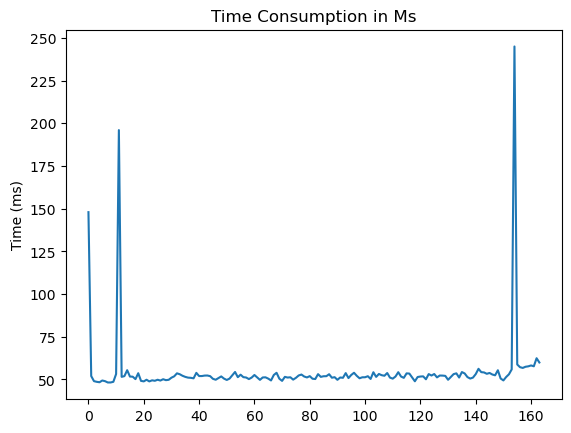

In [20]:
plt.plot(cost_times)
plt.title('Time Consumption in Ms')
plt.ylabel('Time (ms)')

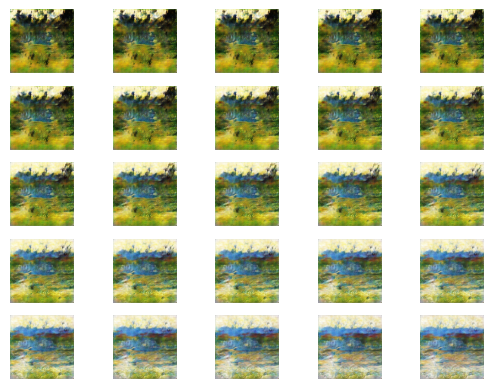

In [35]:
## Preview
n = 5
for i in range(n * n):
	# define subplot
	plt.subplot(n, n, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(generated_images[i])

In [33]:
import imageio
from PIL import Image
import numpy as np

# Specify the path for the output GIF
output_gif_path = 'gifs/wikiart_sndcgan256_hinge_impressionism_4_600.gif'

new_width = 512
new_height = 512

with imageio.get_writer(output_gif_path, mode='I', duration=0.05) as writer:
    for image in generated_images:
        # Convert the NumPy array to a PIL Image object
        img = Image.fromarray((image * 255).astype(np.uint8))
        # Resize the image
        img = img.resize((new_width, new_height), Image.NEAREST)
        # Convert the PIL Image back to a NumPy array
        img_resized = np.array(img)
        # Append the resized image to the GIF
        writer.append_data(img_resized)

print("GIF saved at:", output_gif_path)

GIF saved at: gifs/wikiart_sndcgan256_hinge_impressionism_3_600.gif
